# Nuclear Physics example
In this notebook I'll go through an example similar to methods I'm using as part of my summer project.

**NOTE:** Data is NOT included for this example, contact me if you want to access it.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from root_pandas import read_root
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, AlphaDropout, Activation
from keras.optimizers import SGD, Adam, Nadam
from keras import initializers

Welcome to JupyROOT 6.12/06


Using TensorFlow backend.


## Data
Here the data is measurements of energy, flight-time, angles .etc for electrons, protons, pi+ and pi-.

There are various python packages that allow ROOT trees to be loaded. Pandas is a powerful python package for managing large datasets in dataframes, that some what resemble ROOT TTree, and has a version that can handle ROOT files.

In [2]:
df = read_root('Data2Pi.root', key='HSParticles')

### What are we dealing with?

In [3]:
print('Columns in dataframe:')
print(df.columns.tolist())

Columns in dataframe:
['MissMass2', 'MissMass', 'Topo', 'NPerm', 'NDet', 'Detector', 'Correct', 'ElTime', 'ElEdep', 'ElDeltaE', 'ElPreE', 'ElP', 'ElTh', 'ElPhi', 'ElVz', 'ElTrChi2', 'ElDet', 'PTime', 'PEdep', 'PDeltaE', 'PPreE', 'PP', 'PTh', 'PPhi', 'PVz', 'PTrChi2', 'PDet', 'PipTime', 'PipEdep', 'PipDeltaE', 'PipPreE', 'PipP', 'PipTh', 'PipPhi', 'PipVz', 'PipTrChi2', 'PipDet', 'PimTime', 'PimEdep', 'PimDeltaE', 'PimPreE', 'PimP', 'PimTh', 'PimPhi', 'PimVz', 'PimTrChi2', 'PimDet', 'UID']


We won't use all this information in training. Variables like MissMass2 are saved for later anaylis and variables like 'UID' are useful for training.

### Preprocessing

In [4]:
# remove all NaNs and infs
pd.options.mode.use_inf_as_na = True    # make sure infs count as NaN values
df = df.fillna(value = 0)

A lot more preprocessing could be done based on the infomation we have, such as topologies and where the particles were detected, but this isn't necessary for the purposes of this example.

### Set the input arrays

In [5]:
Nevents = 1e5

In [6]:
# drop columns and convery to numpy array
dfX = df.drop(['MissMass2', 'MissMass', 'Topo', 'NDet', 'Detector', 'NPerm', 'UID'], axis = 1)
# want even number of signals and background
dfX_signals = dfX[dfX['Correct']==1]
dfX_bkg = dfX[dfX['Correct']==0]
# convert to numpy arrays
X_signals = dfX_signals.drop('Correct', axis = 1).values[:int(Nevents),:]
X_bkg = dfX_bkg.drop('Correct', axis = 1).values[:int(Nevents),:]
# merge back together 
X = np.concatenate([X_signals, X_bkg], axis = 0)
print('Shape of input data: {0}'.format(X.shape))

Shape of input data: (200000, 40)


In [7]:
Y = np.concatenate([np.ones(int(Nevents),), np.zeros(int(Nevents),)])
Y = keras.utils.to_categorical(Y, num_classes=2)
print('Shape of input labels: {0}'.format(Y.shape))

Shape of input labels: (200000, 2)


In [8]:
# shuffle in manner
idx = np.arange(0, X.shape[0], 1)
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [11]:
# split the data
cut_idx = int(0.9 * X.shape[0])
x_train, x_test = X[:cut_idx,:], X[cut_idx:,:]
y_train, y_test = Y[:cut_idx,:], Y[cut_idx:,:]
print('Number of training/validation samples: {0}'.format(x_train.shape[0]))
print('Number of testing samples: {0}'.format(x_test.shape[0]))

Number of training/validation samples: 180000
Number of testing samples: 20000


## The Model

Here is a a variation of a normal neural net called a [self-normalizing neural net](https://arxiv.org/abs/1706.02515). The activation function, type of dropout and initlization change, but the rest of the network stays much the same. This is a form of neural network developed last year that does not requiere BatchNormalization.

Here, this type of network is used to simply show some the changes that can be made to network, other than just changing layer sizes.

In [12]:
model0 = Sequential()

model0.add(Dense(1024,input_dim=X.shape[-1]))
model0.add(Activation('relu'))
model0.add(Dropout(0.2))

# output layer
model0.add(Dense(2, activation='softmax'))
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              41984     
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 44,034
Trainable params: 44,034
Non-trainable params: 0
_________________________________________________________________


In [13]:
model1 = Sequential()

model1.add(Dense(1024,input_dim=X.shape[-1]))
model1.add(Activation('relu'))
model1.add(AlphaDropout(0.2))

model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(AlphaDropout(0.2))

# output layer
model1.add(Dense(2, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              41984     
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total para

Note the difference in the number of parameters in each model. This will be reflected in the training time.

### Compile

In [14]:
model0.compile(loss='categorical_crossentropy', 
              optimizer= SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=['accuracy',])
model1.compile(loss='categorical_crossentropy', 
              optimizer= SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=['accuracy',])
#SGD(lr=0.01, momentum=0.9, nesterov=True)

### Train

In [15]:
epochs = 10
batch_size = 32

In [16]:
history0 = model0.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model0.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])

print('Test accuracy:', score[1])

Train on 162000 samples, validate on 18000 samples
Epoch 1/10
162000/162000 [==============================] - 9s 59us/step - loss: 0.3230 - acc: 0.8662 - val_loss: 0.2966 - val_acc: 0.8769
Epoch 2/10
162000/162000 [==============================] - 9s 55us/step - loss: 0.2905 - acc: 0.8813 - val_loss: 0.2881 - val_acc: 0.8858
Epoch 3/10
162000/162000 [==============================] - 9s 53us/step - loss: 0.2822 - acc: 0.8862 - val_loss: 0.2731 - val_acc: 0.8904
Epoch 4/10
162000/162000 [==============================] - 9s 54us/step - loss: 0.2768 - acc: 0.8884 - val_loss: 0.2767 - val_acc: 0.8775
Epoch 5/10
162000/162000 [==============================] - 9s 54us/step - loss: 0.2728 - acc: 0.8898 - val_loss: 0.2678 - val_acc: 0.8883
Epoch 6/10
162000/162000 [==============================] - 9s 55us/step - loss: 0.2698 - acc: 0.8911 - val_loss: 0.2654 - val_acc: 0.8939
Epoch 7/10
162000/162000 [==============================] - 9s 55us/step - loss: 0.2675 - acc: 0.8924 - val_loss: 0

2018-07-11 17:26:29.216458: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [17]:
history1 = model1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])

print('Test accuracy:', score[1])

Train on 162000 samples, validate on 18000 samples
Epoch 1/10
162000/162000 [==============================] - 33s 201us/step - loss: 0.6284 - acc: 0.6889 - val_loss: 0.3612 - val_acc: 0.8526
Epoch 2/10
162000/162000 [==============================] - 32s 197us/step - loss: 0.4632 - acc: 0.7987 - val_loss: 0.3745 - val_acc: 0.8618
Epoch 3/10
162000/162000 [==============================] - 32s 198us/step - loss: 0.4302 - acc: 0.8155 - val_loss: 0.3908 - val_acc: 0.8608
Epoch 4/10
162000/162000 [==============================] - 32s 199us/step - loss: 0.4206 - acc: 0.8209 - val_loss: 0.3813 - val_acc: 0.8633
Epoch 5/10
162000/162000 [==============================] - 32s 197us/step - loss: 0.4141 - acc: 0.8230 - val_loss: 0.3606 - val_acc: 0.8644
Epoch 6/10
162000/162000 [==============================] - 32s 195us/step - loss: 0.4052 - acc: 0.8284 - val_loss: 0.3756 - val_acc: 0.8648
Epoch 7/10
162000/162000 [==============================] - 32s 199us/step - loss: 0.4026 - acc: 0.8282

### Loss

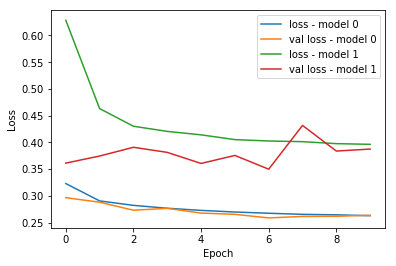

In [18]:
fig, ax = plt.subplots(1,1)
ax.plot(history0.history['loss'], label = 'loss - model 0')
ax.plot(history0.history['val_loss'], label = 'val loss - model 0')
ax.plot(history1.history['loss'], label = 'loss - model 1')
ax.plot(history1.history['val_loss'], label = 'val loss - model 1')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

## Results

In [19]:
y_preds0 = model0.predict(x_test)
y_preds1 = model1.predict(x_test)

In [20]:
from sklearn import metrics
import itertools

### ROC curve

In [21]:
fp0, tp0, _ = metrics.roc_curve(y_test[:,1], y_preds0[:,1])
fp1, tp1, _ = metrics.roc_curve(y_test[:,1], y_preds1[:,1])

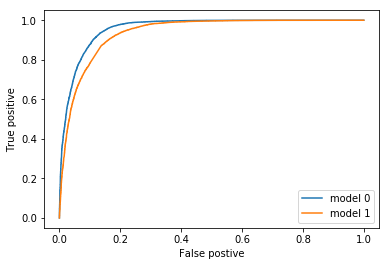

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(fp0, tp0, label = 'model 0')
ax.plot(fp1, tp1, label = 'model 1')
ax.set_xlabel('False postive')
ax.set_ylabel('True positive')
plt.legend()
plt.show()

### Confusion matrix

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
# cm needs predicted class
y_preds_rounded = np.argmax(y_preds0, axis =1)

In [27]:
cm = metrics.confusion_matrix(y_test[:,1], y_preds_rounded)

Normalized confusion matrix
[[0.82112112 0.17887888]
 [0.02977023 0.97022977]]


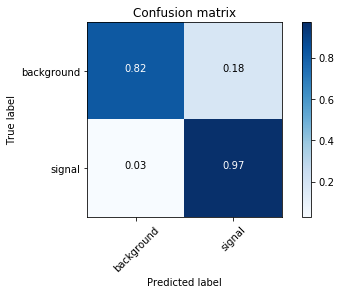

In [28]:
plot_confusion_matrix(cm, ['background', 'signal'], normalize=True)